In [41]:
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures, DropCorrelatedFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_station_info = pd.read_csv('Base Station basic information.csv')
cell_level_data = pd.read_csv('Cell-level data.csv')
energy_consumption_data = pd.read_csv('Energy consumption data.csv')

In [3]:
print('Size of base_station_info', base_station_info.shape)
print('Size of cell_level_data', cell_level_data.shape)
print('Size of energy_consumption_data', energy_consumption_data.shape)

Size of base_station_info (1217, 8)
Size of cell_level_data (125575, 10)
Size of energy_consumption_data (92629, 3)


In [4]:
print('Duplicate of base_station_info', base_station_info.duplicated().sum())
print('Duplicate of cell_level_data', cell_level_data.duplicated().sum())
print('Duplicate of energy_consumption_data', energy_consumption_data.duplicated().sum())

Duplicate of base_station_info 0
Duplicate of cell_level_data 0
Duplicate of energy_consumption_data 0


In [5]:
base_station_info.sample(5)

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower
273,B_273,Cell0,Type4,Mode2,532.0,20,2,6.875934
236,B_236,Cell0,Type1,Mode2,365.0,20,2,6.875934
357,B_357,Cell0,Type1,Mode2,365.0,20,2,6.875934
1193,B_745,Cell1,Type1,Mode2,365.0,20,2,6.875934
626,B_626,Cell0,Type1,Mode2,365.0,20,2,6.875934


In [6]:
cell_level_data.sample(5)

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6
39412,1/2/2023 12:00,B_284,Cell0,0.30858,0.0,0.0,0.0,0,0.0,0.0
2180,1/6/2023 20:00,B_15,Cell0,0.02344,0.0,0.0,0.0,0,0.0,0.0
87942,1/6/2023 14:00,B_632,Cell0,0.35063,0.0,0.0,0.0,0,0.0,0.0
62871,1/3/2023 10:00,B_454,Cell0,0.02477,0.0,0.0,0.0,0,0.0,0.0
21817,1/4/2023 18:00,B_157,Cell0,0.25836,0.0,0.0,0.0,0,0.0,0.0


In [7]:
energy_consumption_data.sample(5)

,Time,BS,Energy
31263,1/2/2023 6:00,B_284,18.834081
8077,1/6/2023 16:00,B_73,27.653214
46233,1/4/2023 20:00,B_421,11.210762
92157,1/2/2023 2:00,B_974,12.406577
76039,1/5/2023 17:00,B_689,44.992526


In [8]:
cell_level_with_energy = pd.merge(energy_consumption_data, cell_level_data, on= ['BS', 'Time'], how = 'left')

In [9]:
cell_level_with_energy.shape

(98084, 11)

In [10]:
energy_consumption_data.tail()

,Time,BS,Energy
92624,1/2/2023 17:00,B_1018,14.648729
92625,1/2/2023 18:00,B_1018,14.648729
92626,1/2/2023 21:00,B_1018,13.452915
92627,1/2/2023 22:00,B_1018,13.602392
92628,1/2/2023 23:00,B_1018,13.303438


In [11]:
train_data = pd.merge(cell_level_with_energy, base_station_info, on= ['CellName','BS'], how = 'left')

In [12]:
train_data.shape

(98084, 17)

In [13]:
train_data.isna().sum()

Time         0
BS           0
Energy       0
CellName     0
load         0
ESMode1      0
ESMode2      0
ESMode3      0
ESMode4      0
ESMode5      0
ESMode6      0
RUType       0
Mode         0
Frequency    0
Bandwidth    0
Antennas     0
TXpower      0
dtype: int64

In [14]:
#describe numerical column
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Energy,98084.0,28.986888,14.345648,0.747384,18.535127,24.962631,37.668161,100.000000
load,98084.0,0.242025,0.236798,0.000000,0.055922,0.157570,0.358069,0.993957
ESMode1,98084.0,0.039012,0.187290,0.000000,0.000000,0.000000,0.000000,1.000000
ESMode2,98084.0,0.037728,0.184540,0.000000,0.000000,0.000000,0.000000,1.000000
ESMode3,98084.0,0.000082,0.002393,0.000000,0.000000,0.000000,0.000000,0.154563
ESMode4,98084.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ESMode5,98084.0,0.000014,0.003171,0.000000,0.000000,0.000000,0.000000,0.768070
ESMode6,98084.0,0.030367,0.149012,0.000000,0.000000,0.000000,0.000000,0.931032
Frequency,98084.0,368.979381,136.286959,155.600000,189.000000,365.000000,532.000000,979.998000
Bandwidth,98084.0,15.965917,5.645188,2.000000,10.000000,20.000000,20.000000,20.000000


In [ ]:
frequency, bandwidth, amtennas, txpower need to be scaled

In [15]:
#describe categorical column
train_data.describe(include = ['O'])

,Time,BS,CellName,RUType,Mode
count,98084,98084,98084,98084,98084
unique,168,923,4,12,2
top,1/2/2023 23:00,B_745,Cell0,Type4,Mode2
freq,937,270,92629,25677,97429


In [16]:
# Check unique value for each attribute
train_data.nunique()

Time           168
BS             923
Energy         612
CellName         4
load         59282
ESMode1        509
ESMode2       1104
ESMode3        169
ESMode4          1
ESMode5          4
ESMode6       4200
RUType          12
Mode             2
Frequency        8
Bandwidth        5
Antennas         6
TXpower         33
dtype: int64

In [17]:
quantitative = []
qualitative = []
for i in train_data.columns:
    if train_data.dtypes[i] != 'object':
        quantitative.append(i)
    else:
        qualitative.append(i)
print('Numerical :: ', quantitative)
print('\nCatagorical :: ', qualitative)

Numerical ::  ['Energy', 'load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode4', 'ESMode5', 'ESMode6', 'Frequency', 'Bandwidth', 'Antennas', 'TXpower']

Catagorical ::  ['Time', 'BS', 'CellName', 'RUType', 'Mode']


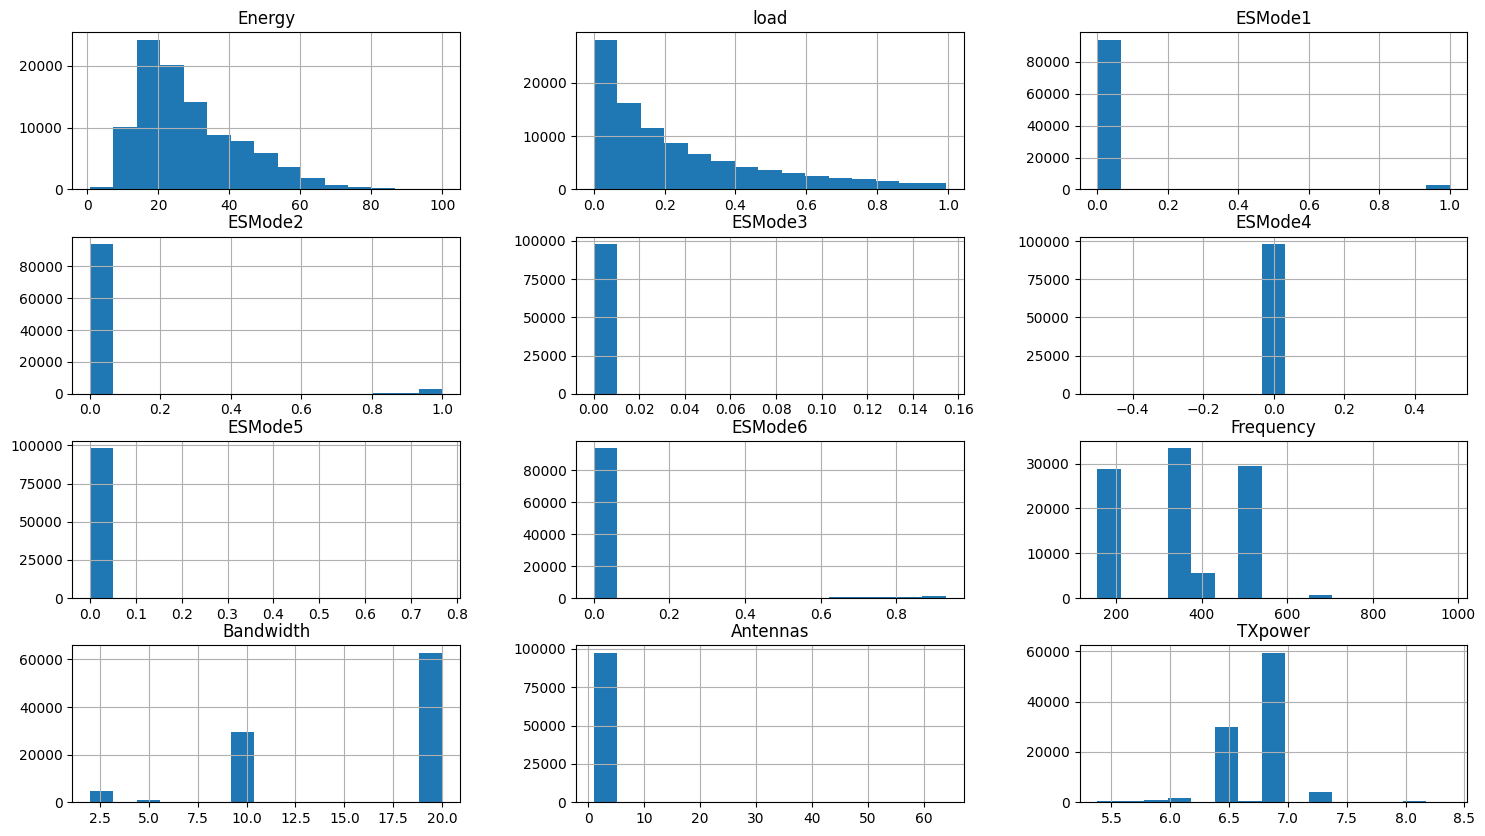

In [18]:
#Analyzing nuumerical variable
train_data[quantitative].hist(bins=15, figsize=(18, 10));

# Feature Engineering

In [19]:
train_data['Time'] = pd.to_datetime(train_data['Time'])
train_data['day'] = [i.day for i in train_data.Time]
train_data['day_of_year'] = [i.dayofyear for i in train_data.Time]
train_data['month'] = [i.month for i in train_data.Time]
train_data['hour'] = [i.hour for i in train_data.Time]
train_data['is_weekday'] = [i.isoweekday() for i in train_data.Time]

In [20]:
#  This can be particularly useful when the effect of the datetime column might be different for different categorical groups.
#Convert datetime column to numerical features (e.g., days since a reference date)
train_data['datetime_column'] = (train_data['Time'] - train_data['Time'].min()).dt.days
#test_data['datetime_column'] = (X_test['datetime_column'] - X_train['datetime_column'].min()).dt.days
# Convert datetime column to numerical features within categorical groups
for col in categorical_cols:
    min_date_per_group = X_train.groupby(col)['datetime_column'].min()
    X_test['datetime_column'] = (
        X_test.apply(lambda row: (row['datetime_column'] - min_date_per_group[row[col]]).days, axis=1)
    )

NameError: name 'categorical_cols' is not defined

In [21]:
train_data.datetime_column.nunique()

7

In [22]:
#Searching for Duplicated or Quasi-constant features
sel = DropConstantFeatures(tol=0.99, variables=None)

sel.fit(train_data)

features_to_drop = list(sel.features_to_drop_)
print(features_to_drop)

['ESMode3', 'ESMode4', 'ESMode5', 'Mode', 'month']


In [23]:
#Looking for Correlated Features
sel = DropCorrelatedFeatures(threshold=0.80,    # more than 80% = remove
                             method='pearson') # you can use other methods like kendall or spearman

sel.fit(train_data)

features_to_drop = features_to_drop + list(sel.features_to_drop_)
features_to_drop = list(set(features_to_drop))
print('Features to drop', sel.features_to_drop_)
print()
print('Correlated Feature Sets', sel.correlated_feature_sets_)

Features to drop {'datetime_column', 'day_of_year', 'ESMode2'}

Correlated Feature Sets [{'ESMode1', 'ESMode2'}, {'datetime_column', 'day', 'day_of_year'}]


In [24]:
features_to_drop

['ESMode3',
 'day_of_year',
 'Mode',
 'ESMode4',
 'ESMode2',
 'datetime_column',
 'month',
 'ESMode5']

In [25]:
train_data.drop(features_to_drop, axis=1, inplace=True)

# Target Variable check

<Axes: ylabel='Density'>

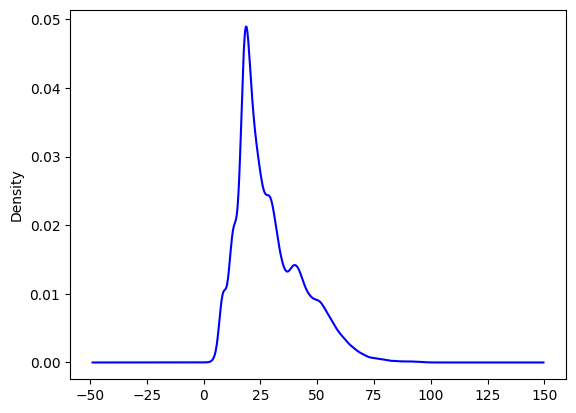

In [26]:
train_data['Energy'].plot.density(color='blue')

<Axes: xlabel='Energy', ylabel='Density'>

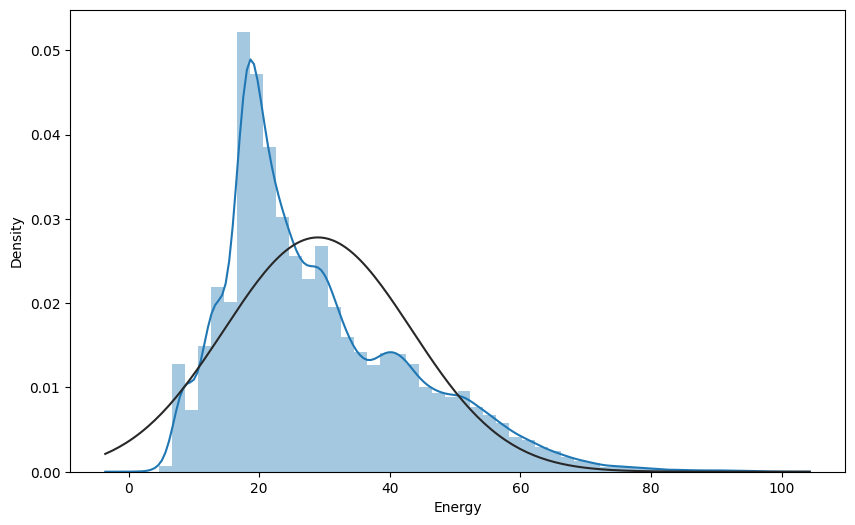

In [27]:
plt.figure(figsize=(10,6))
sns.distplot(train_data['Energy'], fit=st.norm)

In [29]:
train_data.head(3)

,Time,BS,Energy,CellName,load,ESMode1,ESMode6,RUType,Frequency,Bandwidth,Antennas,TXpower,day,hour,is_weekday
0,2023-01-01 01:00:00,B_0,64.275037,Cell0,0.487936,0.0,0.0,Type1,365.0,20,4,6.875934,1,1,7
1,2023-01-01 02:00:00,B_0,55.904335,Cell0,0.344468,0.0,0.0,Type1,365.0,20,4,6.875934,1,2,7
2,2023-01-01 03:00:00,B_0,57.698057,Cell0,0.193766,0.0,0.0,Type1,365.0,20,4,6.875934,1,3,7


# Model

In [30]:
# Separate features and target
features = train_data.drop(columns=['Energy'])
target = train_data['Energy']

In [35]:
quantitative = []
qualitative = []
for i in train_data.columns:
    if train_data.dtypes[i] != 'object':
        quantitative.append(i)
    else:
        qualitative.append(i)
print('Numerical :: ', quantitative)
print('\nCatagorical :: ', qualitative)

Numerical ::  ['Time', 'Energy', 'load', 'ESMode1', 'ESMode6', 'Frequency', 'Bandwidth', 'Antennas', 'TXpower', 'day', 'hour', 'is_weekday']

Catagorical ::  ['BS', 'CellName', 'RUType']


In [61]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Preprocess categorical columns using label encoding
label_encoders = {}
for col in qualitative:
    print(col)
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

BS
CellName
RUType


In [62]:
X_train.columns

Index(['Time', 'BS', 'CellName', 'load', 'ESMode1', 'ESMode6', 'RUType',
       'Frequency', 'Bandwidth', 'Antennas', 'TXpower', 'day', 'hour',
       'is_weekday'],
      dtype='object')

In [65]:
# Normalize numerical columns using StandardScaler
#frequency, bandwidth, amtennas, txpower need to be scaled
numerical_cols = ['Frequency', 'Bandwidth', 'Antennas', 'TXpower']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [66]:
X_train.drop(['Time'], axis = 1, inplace = True)

KeyError: "['Time'] not found in axis"

In [71]:
X_test.drop(['Time'], axis = 1, inplace = True)

In [67]:

model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())  # Add BatchNormalization
model.add(Dropout(0.2))  # Add Dropout for regularization
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())  # Add BatchNormalization
model.add(Dropout(0.2))  # Add Dropout for regularization
model.add(Dense(1, activation='linear'))
model.compile(loss='mae', optimizer='sgd', metrics=['mae'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 8)                 112       
                                                                 
 batch_normalization_2 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 8)                 72        
                                                                 
 batch_normalization_3 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 8)                

In [68]:
model.fit(X_train, y_train,epochs=5, batch_size=1, verbose=1)

Epoch 1/2
78467/78467 [==============================] - 149s 2ms/step - loss: 11.3135 - mae: 11.3135
Epoch 2/2
78467/78467 [==============================] - 158s 2ms/step - loss: 11.0993 - mae: 11.0993


In [72]:
y_pred = model.predict(X_test)
score = model.evaluate(X_test, y_test,verbose=1)
print(score)

614/614 [==============================] - 2s 2ms/step - loss: 1887.2445 - mae: 1887.2445
[1887.2445068359375, 1887.2445068359375]


# Submission

In [73]:
power_consumption_prediction = pd.read_csv('power_consumption_prediction.csv')

In [74]:
power_consumption_prediction.shape

(26139, 4)

In [75]:
power_consumption_prediction.head()

,Time,BS,Energy,w
0,2023-01-01 06:00:00,B_0,NaN,1
1,2023-01-01 11:00:00,B_0,NaN,1
2,2023-01-01 12:00:00,B_0,NaN,1
3,2023-01-01 13:00:00,B_0,NaN,1
4,2023-01-01 23:00:00,B_0,NaN,1


In [76]:
print('Duplicate of power_consumption_prediction', power_consumption_prediction.duplicated().sum())

Duplicate of power_consumption_prediction 0


In [77]:
w = power_consumption_prediction.w.tolist()
power_consumption_prediction.drop(['Energy','w'],axis = 1, inplace = True)

In [78]:
power_consumption_prediction['Time'] = pd.to_datetime(power_consumption_prediction['Time'])
cell_level_data['Time'] = pd.to_datetime(cell_level_data['Time'])

In [79]:
cell_level_with_energy_test = pd.merge(power_consumption_prediction, cell_level_data, on= ['BS', 'Time'], how = 'left')

test_data = pd.merge(cell_level_with_energy_test, base_station_info, on= ['CellName','BS'], how = 'left')



In [80]:
test_data['day'] = [i.day for i in test_data.Time]
test_data['day_of_year'] = [i.dayofyear for i in test_data.Time]
test_data['month'] = [i.month for i in test_data.Time]
test_data['hour'] = [i.hour for i in test_data.Time]
test_data['is_weekday'] = [i.isoweekday() for i in test_data.Time]

In [81]:
features_to_drop

['ESMode3',
 'day_of_year',
 'Mode',
 'ESMode4',
 'ESMode2',
 'datetime_column',
 'month',
 'ESMode5']

In [82]:

test_data['datetime_column'] = (test_data['Time'] - test_data['Time'].min()).dt.days

test_data.drop(features_to_drop, axis=1, inplace=True)


test_data.drop(['Time'], axis = 1, inplace = True)

# Preprocess categorical columns using label encoding


for col, le in label_encoders.items():
    try:
        test_data[col] = le.transform(test_data[col])
    except:
        le = LabelEncoder()
        test_data[col] = le.fit_transform(test_data[col])

In [87]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
BS,27491.0,467.727365,272.734081,0.000000,236.000000,463.000000,693.000000,1017.000000
CellName,27491.0,0.050053,0.223332,0.000000,0.000000,0.000000,0.000000,3.000000
load,27491.0,0.228249,0.231658,0.000000,0.052412,0.139190,0.330575,0.993628
ESMode1,27491.0,0.044107,0.197708,0.000000,0.000000,0.000000,0.000000,1.000000
ESMode6,27491.0,0.068756,0.208067,0.000000,0.000000,0.000000,0.000000,0.930545
RUType,27491.0,5.019461,3.346208,0.000000,0.000000,6.000000,8.000000,11.000000
Frequency,27491.0,0.153115,1.212092,-1.564384,-1.319436,-0.028694,1.196044,4.481555
Bandwidth,27491.0,-0.151051,1.084042,-2.474733,-1.057072,0.715005,0.715005,0.715005
Antennas,27491.0,0.660488,4.318696,-0.585884,-0.090933,-0.090933,-0.090933,30.596064
TXpower,27491.0,0.172672,1.455469,-4.443319,-1.004503,0.469276,0.469276,5.397099


In [88]:
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

In [89]:
energy_pred = model.predict(test_data)

860/860 [==============================] - 1s 2ms/step


In [91]:
len(energy_pred.tolist())


27491